In [1]:
import dotenv
dotenv.load_dotenv()

import os
from openai import OpenAI
import json
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

transcript = """
Imagine a world where humanity has finally reached the stars and we're not just talking | start: 0.0 | end: 5.28
about any old spacecraft, but the most advanced cutting edge and sustainable vessels that are | start: 5.28 | end: 11.64
changing the game. | start: 11.64 | end: 13.68
Space ships are not just a luxury, they are a necessity. | start: 13.68 | end: 17.04
They are the key to unlocking new frontiers, new discoveries and new possibilities for humanity. | start: 17.04 | end: 23.36
But did you know that the first spaceship | start: 23.36 | end: 25.52
was actually a hot air balloon? Yes, you heard that right. In 1783, French inventor | start: 25.52 | end: 32.74
Montgolfier created the first successful hot air balloon which carried a group of 20 people | start: 32.74 | end: 38.64
to the skies. It was a groundbreaking achievement that paved the way for the development of modern space travel. | start: 38.64 | end: 45.92
Fast forward to today, and we have reusable rockets, advanced propulsion systems, | start: 45.92 | end: 51.44
and even private space companies like SpaceX and Blue Origin pushing the boundaries of what's possible. | start: 51.44 | end: 58.24
But what's even more exciting is that we're not just talking about the technology, | start: 58.24 | end: 63.04
we're talking about the people, the communities, and the cultures that are being shaped by space exploration. | start: 63.04 | end: 70.04
From the astronauts who are pushing the limits of human endurance to the scientists who | start: 70.04 | end: 74.84
are unlocking the secrets of the universe, space travel is not just a dream, it's a reality | start: 74.84 | end: 80.6
that's changing our world. | start: 80.6 | end: 82.76
So let's get ready to blast off into the unknown and explore the infinite possibilities | start: 82.76 | end: 88.04
"""

script = """
You are given a transcript of a short video with timestamps
You are in charge of making a list of pictures that will be used to create a video
The video will be a slideshow of the pictures
The pictures should be relevant to the text
Make sure to include how long each picture should be displayed as well as the description of the picture
Make only 5 images

Example json output
[{"description": "A picture of a cat", "start": 1, "end": 3}, {"description": "A picture of a dog", "start": 3, "end": 5}]
"""


In [2]:
output = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": script},
        {"role": "user", "content": transcript}
    ],
    response_format={ "type": "json_object" }
)

images = json.loads(output.choices[0].message.content)
images



{'images': [{'description': 'An artistic rendition of a futuristic starship traveling through space with stars and galaxies in the background',
   'start': 0.0,
   'end': 5.28},
  {'description': 'A group of diverse astronauts and engineers working on a cutting-edge spacecraft',
   'start': 5.28,
   'end': 11.64},
  {'description': 'A historical painting or illustration of the first hot air balloon by Montgolfier taking flight',
   'start': 23.36,
   'end': 32.74},
  {'description': 'A picture of a modern reusable rocket launching, like a SpaceX Falcon 9',
   'start': 45.92,
   'end': 51.44},
  {'description': 'A collage of astronauts floating in space, scientists working in laboratories, and communities engaged in space-related activities',
   'start': 63.04,
   'end': 70.04}]}

In [3]:
from pathlib import Path
from optimum.intel.openvino import OVStableDiffusionXLPipeline
import gc

def setup_sdxl_base_model(model_id="stabilityai/stable-diffusion-xl-base-1.0",
                          model_dir="openvino-sd-xl-base-1.0",
                          device="AUTO",
                          compress_weights=True):
    """
    Downloads and converts the SDXL Base model to OpenVINO IR format.
    
    Args:
        model_id (str): Hugging Face model ID.
        model_dir (str): Directory to save the converted model.
        device (str): Inference device ('CPU', 'GPU.0', etc.).
        compress_weights (bool): Whether to apply 8-bit weight compression.
    
    Returns:
        OVStableDiffusionXLPipeline: The optimized pipeline.
    """
    from optimum.intel import OVWeightQuantizationConfig

    model_path = Path(model_dir)
    quantization_config = OVWeightQuantizationConfig(bits=8) if compress_weights else None

    if not model_path.exists():
        pipeline = OVStableDiffusionXLPipeline.from_pretrained(
            model_id,
            compile=False,
            device=device,
            quantization_config=quantization_config
        )
        pipeline.half()
        pipeline.save_pretrained(model_path)
        pipeline.compile()
    else:
        pipeline = OVStableDiffusionXLPipeline.from_pretrained(
            model_path,
            device=device
        )
    gc.collect()
    return pipeline

# Setup Base Model
base_pipeline = setup_sdxl_base_model(
    device="CPU",
)

import numpy as np
from pathlib import Path
from PIL import Image
import gc

def generate_image(
    prompt,
    base_pipeline,
    output_path="generated_image.png",
    model_id="stabilityai/stable-diffusion-xl-base-1.0",
    model_dir="openvino-sd-xl-base-1.0",
    device="AUTO",
    num_inference_steps=15,
    height=512,
    width=512,
    seed=314
):
    """
    Generates an image from a text prompt using the SDXL Base model and OpenVINO.

    Args:
        prompt (str): The text prompt for image generation.
        output_path (str): Path to save the generated image.
        model_id (str): Hugging Face SDXL Base model ID.
        model_dir (str): Directory for the converted SDXL Base model.
        device (str): Inference device ('CPU', 'GPU.0', etc.).
        compress_weights (bool): Whether to apply 8-bit weight compression.
        num_inference_steps (int): Number of inference steps for generation.
        height (int): Height of the generated image in pixels.
        width (int): Width of the generated image in pixels.
        seed (int): Random seed for reproducibility.

    Returns:
        PIL.Image.Image: The generated image.
    """    # Generate Image
    print("Generating image...")
    image = base_pipeline(
        prompt=prompt,
        num_inference_steps=num_inference_steps,
        height=height,
        width=width,
        generator=np.random.RandomState(seed)
    ).images[0]

    # Save Image
    image.save(output_path)
    print(f"Image saved to {output_path}")

    # Cleanup
    del base_pipeline
    gc.collect()

    return image


Compiling the vae_decoder to CPU ...
Compiling the unet to CPU ...
Compiling the text_encoder to CPU ...
Compiling the text_encoder_2 to CPU ...
Compiling the vae_encoder to CPU ...


In [4]:
import matplotlib.pyplot as plt

images_output = []
for image in images['images']:
    print(image)
    images_output.append(generate_image(image["description"], base_pipeline))

{'description': 'An artistic rendition of a futuristic starship traveling through space with stars and galaxies in the background', 'start': 0.0, 'end': 5.28}
Generating image...


  0%|          | 0/15 [00:00<?, ?it/s]

Image saved to generated_image.png
{'description': 'A group of diverse astronauts and engineers working on a cutting-edge spacecraft', 'start': 5.28, 'end': 11.64}
Generating image...


  0%|          | 0/15 [00:00<?, ?it/s]

Image saved to generated_image.png
{'description': 'A historical painting or illustration of the first hot air balloon by Montgolfier taking flight', 'start': 23.36, 'end': 32.74}
Generating image...


  0%|          | 0/15 [00:00<?, ?it/s]

Image saved to generated_image.png
{'description': 'A picture of a modern reusable rocket launching, like a SpaceX Falcon 9', 'start': 45.92, 'end': 51.44}
Generating image...


  0%|          | 0/15 [00:00<?, ?it/s]

Image saved to generated_image.png
{'description': 'A collage of astronauts floating in space, scientists working in laboratories, and communities engaged in space-related activities', 'start': 63.04, 'end': 70.04}
Generating image...


  0%|          | 0/15 [00:00<?, ?it/s]

Image saved to generated_image.png


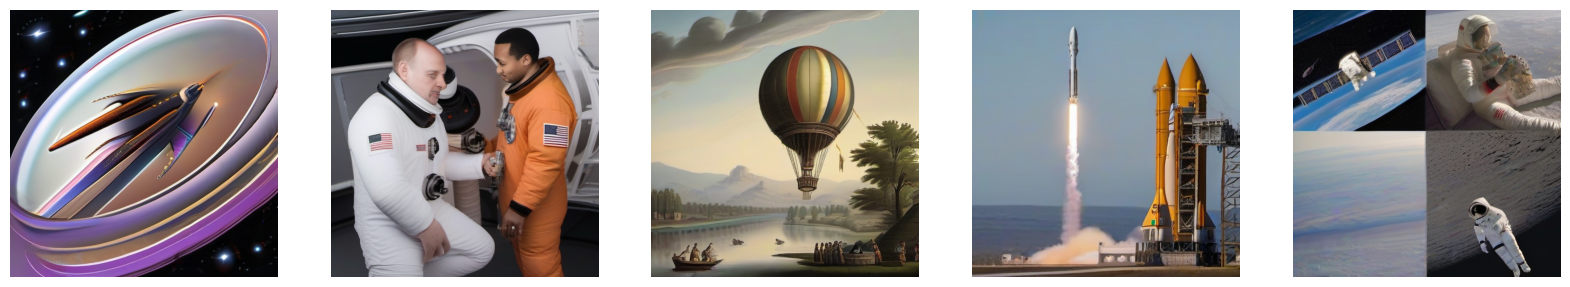

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i, image in enumerate(images_output):
    ax[i].imshow(image)
    ax[i].axis('off')
plt.show()
